Week 7 Notebook: Optimizing Other Objectives
===============================================================

This week, we will look at optimizing multiple objectives simultaneously. In particular, we will look at pivoting with adversarial neural networks {cite}`Louppe:2016ylz,ganin2014unsupervised,Sirunyan:2019nfw`.

We will borrow the implementation from: <https://github.com/glouppe/paper-learning-to-pivot>

In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

Using TensorFlow backend.


In [2]:
# 48 track-level features
features = ['track_pt',
            'track_ptrel',
            'trackBTag_Eta',
            'trackBTag_DeltaR',
            'trackBTag_EtaRel',
            'trackBTag_JetDistVal',
            'trackBTag_Momentum',
            'trackBTag_PPar',
            'trackBTag_PParRatio',
            'trackBTag_PtRatio',
            'trackBTag_PtRel',
            'trackBTag_Sip2dSig',
            'trackBTag_Sip2dVal',
            'trackBTag_Sip3dSig',
            'trackBTag_Sip3dVal',
            'track_VTX_ass',
            'track_charge',
            'track_deltaR',
            'track_detadeta',
            'track_dlambdadz',
            'track_dlambdadz',
            'track_dphidphi',
            'track_dphidxy',
            'track_dptdpt',
            'track_drminsv',
            'track_drsubjet1',
            'track_drsubjet2',
            'track_dxy',
            'track_dxydxy',
            'track_dxydz',
            'track_dxysig',
            'track_dz',
            'track_dzdz',        
            'track_dzsig',
            'track_erel',
            'track_etarel',
            'track_fromPV',
            'track_isChargedHad',
            'track_isEl',
            'track_isMu',
            'track_lostInnerHits',
            'track_mass',
            'track_normchi2',            
            'track_phirel',
            'track_pt',
            'track_ptrel',
            'track_puppiw',
            'track_quality']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb (we'll reduce the following labels)
labels =  ['label_QCD_b',
           'label_QCD_bb',
           'label_QCD_c', 
           'label_QCD_cc', 
           'label_QCD_others',
           'sample_isQCD',
           'label_H_bb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = 2

# we're going to zero-pad up to 60 tracks
ntracks = 60

In [3]:
from DataGenerator import DataGenerator

## Define Discriminator, Regressor, and Combined Adversarial Model

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda, Concatenate
import tensorflow.keras.backend as K

# define Deep Sets model with Conv1D Keras layer
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv1D(64, 1, strides=1, padding='same', name = 'conv1d_1', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_2', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_3', activation='relu')(x)
# sum over tracks
x = Lambda(lambda x: K.mean(x, axis=-2), name = 'lambda_1', input_shape=(ntracks,32))(x)
x = Dense(100, name = 'dense_1', activation='relu')(x)
output = Dense(nlabels, name = 'output', activation='softmax')(x)
    
keras_model_disc = Model(inputs=inputs, outputs=output)
keras_model_disc.compile(optimizer='adam',
                        loss='categorical_crossentropy')

# regressor
x = Dense(100, name='dense_2', activation ='relu')(keras_model_disc(inputs))
x = Dense(100, name= 'dense_3',activation='relu')(x)
output_reg = Dense(2, activation='linear', name='mass_pt_reg')(x)
                                                            

sgd_opt = keras.optimizers.SGD(momentum=0)
keras_model_reg = Model(inputs=inputs, outputs=output_reg)
keras_model_reg.compile(optimizer=sgd_opt,
                        loss='mse')

# combined model
lam = 0.001
keras_model_adv = Model(inputs=inputs, outputs=[keras_model_disc(inputs), keras_model_reg(inputs)])
keras_model_adv.compile(optimizer=sgd_opt, 
                        loss=['categorical_crossentropy', 'mse'],
                        loss_weights = [1, -lam])                              

print(keras_model_disc.summary())
print(keras_model_reg.summary())
print(keras_model_adv.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 60, 48)            0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            3136      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 32)            2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 32)            1056      
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300

In [5]:
# load training and validation generators 
train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
val_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=5000,
                                return_spectators=True, scale_mass_pt=[100.,10000.])

val_generator = DataGenerator(val_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                              remove_mass_pt_window=False, 
                              remove_unlabeled=True, max_entry=5000, 
                              return_spectators=True, scale_mass_pt=[100.,10000.])

In [6]:
# pretrain discriminator
keras_model_disc.trainable = True
keras_model_disc.compile(optimizer='adam',
                        loss='categorical_crossentropy')
for n in range(20):
    for t in train_generator:
        keras_model_disc.fit(t[0], t[1][0],verbose=1)        
        
# pretrain regressor
keras_model_reg.trainable = True
keras_model_disc.trainable = False
keras_model_reg.compile(optimizer=sgd_opt, loss='mse')
for n in range(20):
    for t in train_generator:
        keras_model_reg.fit(t[0], t[1][1], verbose=1)                 

Epoch 1/1
943/943 [==============================] - 2s 2ms/step - loss: 0.4702
Epoch 1/1
950/950 [==============================] - 0s 194us/step - loss: 0.3813
Epoch 1/1
967/967 [==============================] - 0s 181us/step - loss: 0.3747
Epoch 1/1
954/954 [==============================] - 0s 184us/step - loss: 0.3165
Epoch 1/1
943/943 [==============================] - 0s 142us/step - loss: 0.3251
Epoch 1/1
950/950 [==============================] - 0s 143us/step - loss: 0.2878
Epoch 1/1
967/967 [==============================] - 0s 145us/step - loss: 0.2784
Epoch 1/1
954/954 [==============================] - 0s 141us/step - loss: 0.2344
Epoch 1/1
943/943 [==============================] - 0s 146us/step - loss: 0.2325
Epoch 1/1
950/950 [==============================] - 0s 139us/step - loss: 0.2617
Epoch 1/1
967/967 [==============================] - 0s 143us/step - loss: 0.2409
Epoch 1/1
954/954 [==============================] - 0s 141us/step - loss: 0.2114
Epoch 1/1
943/943 

943/943 [==============================] - 0s 69us/step - loss: 0.6654
Epoch 1/1
950/950 [==============================] - 0s 69us/step - loss: 0.4353
Epoch 1/1
967/967 [==============================] - 0s 70us/step - loss: 0.4442
Epoch 1/1
954/954 [==============================] - 0s 67us/step - loss: 0.7199
Epoch 1/1
943/943 [==============================] - 0s 68us/step - loss: 0.6636
Epoch 1/1
950/950 [==============================] - 0s 69us/step - loss: 0.4340
Epoch 1/1
967/967 [==============================] - 0s 68us/step - loss: 0.4440
Epoch 1/1
954/954 [==============================] - 0s 68us/step - loss: 0.7200
Epoch 1/1
943/943 [==============================] - 0s 69us/step - loss: 0.6618
Epoch 1/1
950/950 [==============================] - 0s 72us/step - loss: 0.4333
Epoch 1/1
967/967 [==============================] - 0s 69us/step - loss: 0.4416
Epoch 1/1
954/954 [==============================] - 0s 69us/step - loss: 0.7201
Epoch 1/1
943/943 [===================

In [7]:
# alternate training discriminator and regressor                    
for n_epoch in range(40):
    for t in train_generator:
        # train discriminator
        keras_model_reg.trainable = False
        keras_model_disc.trainable = True
        keras_model_adv.compile(optimizer=sgd_opt, 
                        loss=['categorical_crossentropy', 'mse'],
                        loss_weights = [1, -lam])    
        keras_model_adv.fit(t[0], t[1], verbose=1)

        # train regressor
        keras_model_reg.trainable = True
        keras_model_disc.trainable = False
        keras_model_reg.compile(optimizer=sgd_opt, loss='mse')
        keras_model_reg.fit(t[0], t[1][1],verbose=1)
keras_model_adv.save_weights('keras_model_adv_best.h5')

Epoch 1/1
943/943 [==============================] - 0s 484us/step - loss: 0.0788 - model_1_loss: 0.0788 - model_2_loss: 0.6502
Epoch 1/1
943/943 [==============================] - 0s 216us/step - loss: 0.6627
Epoch 1/1
950/950 [==============================] - 1s 540us/step - loss: 0.1175 - model_1_loss: 0.1179 - model_2_loss: 0.4309
Epoch 1/1
950/950 [==============================] - 0s 219us/step - loss: 0.4337
Epoch 1/1
967/967 [==============================] - 1s 524us/step - loss: 0.0863 - model_1_loss: 0.0847 - model_2_loss: 0.4352
Epoch 1/1
967/967 [==============================] - 0s 214us/step - loss: 0.4398
Epoch 1/1
954/954 [==============================] - 1s 528us/step - loss: 0.0844 - model_1_loss: 0.0854 - model_2_loss: 0.7173
Epoch 1/1
954/954 [==============================] - 0s 218us/step - loss: 0.7171
Epoch 1/1
943/943 [==============================] - 1s 531us/step - loss: 0.0809 - model_1_loss: 0.0809 - model_2_loss: 0.6818
Epoch 1/1
943/943 [=============

954/954 [==============================] - 0s 523us/step - loss: 0.0834 - model_1_loss: 0.0840 - model_2_loss: 0.7164
Epoch 1/1
954/954 [==============================] - 0s 216us/step - loss: 0.7183
Epoch 1/1
943/943 [==============================] - 0s 528us/step - loss: 0.0812 - model_1_loss: 0.0847 - model_2_loss: 0.6508
Epoch 1/1
943/943 [==============================] - 0s 221us/step - loss: 0.6610
Epoch 1/1
950/950 [==============================] - 1s 527us/step - loss: 0.0973 - model_1_loss: 0.0973 - model_2_loss: 0.4377
Epoch 1/1
950/950 [==============================] - 0s 218us/step - loss: 0.4322
Epoch 1/1
967/967 [==============================] - 0s 516us/step - loss: 0.0810 - model_1_loss: 0.0801 - model_2_loss: 0.4335
Epoch 1/1
967/967 [==============================] - 0s 215us/step - loss: 0.4420
Epoch 1/1
954/954 [==============================] - 0s 521us/step - loss: 0.0791 - model_1_loss: 0.0798 - model_2_loss: 0.7224
Epoch 1/1
954/954 [=======================

967/967 [==============================] - 1s 527us/step - loss: 0.0783 - model_1_loss: 0.0771 - model_2_loss: 0.4328
Epoch 1/1
967/967 [==============================] - 0s 217us/step - loss: 0.4450
Epoch 1/1
954/954 [==============================] - 1s 536us/step - loss: 0.0773 - model_1_loss: 0.0778 - model_2_loss: 0.7350
Epoch 1/1
954/954 [==============================] - 0s 217us/step - loss: 0.7188
Epoch 1/1
943/943 [==============================] - 0s 529us/step - loss: 0.0721 - model_1_loss: 0.0730 - model_2_loss: 0.6613
Epoch 1/1
943/943 [==============================] - 0s 221us/step - loss: 0.6591
Epoch 1/1
950/950 [==============================] - 1s 536us/step - loss: 0.0950 - model_1_loss: 0.0957 - model_2_loss: 0.4288
Epoch 1/1
950/950 [==============================] - 0s 216us/step - loss: 0.4305
Epoch 1/1
967/967 [==============================] - 1s 521us/step - loss: 0.0744 - model_1_loss: 0.0730 - model_2_loss: 0.4363
Epoch 1/1
967/967 [=======================

950/950 [==============================] - 0s 524us/step - loss: 0.0917 - model_1_loss: 0.0917 - model_2_loss: 0.4286
Epoch 1/1
950/950 [==============================] - 0s 219us/step - loss: 0.4322
Epoch 1/1
967/967 [==============================] - 0s 512us/step - loss: 0.0749 - model_1_loss: 0.0736 - model_2_loss: 0.4314
Epoch 1/1
967/967 [==============================] - 0s 212us/step - loss: 0.4365
Epoch 1/1
954/954 [==============================] - 0s 521us/step - loss: 0.0694 - model_1_loss: 0.0704 - model_2_loss: 0.7172
Epoch 1/1
954/954 [==============================] - 0s 216us/step - loss: 0.7136
Epoch 1/1
943/943 [==============================] - 1s 535us/step - loss: 0.0609 - model_1_loss: 0.0607 - model_2_loss: 0.6569
Epoch 1/1
943/943 [==============================] - 0s 221us/step - loss: 0.6576
Epoch 1/1
950/950 [==============================] - 1s 528us/step - loss: 0.0923 - model_1_loss: 0.0979 - model_2_loss: 0.4362
Epoch 1/1
950/950 [=======================

943/943 [==============================] - 0s 524us/step - loss: 0.0672 - model_1_loss: 0.0669 - model_2_loss: 0.6595
Epoch 1/1
943/943 [==============================] - 0s 214us/step - loss: 0.6518
Epoch 1/1
950/950 [==============================] - 0s 511us/step - loss: 0.0914 - model_1_loss: 0.0916 - model_2_loss: 0.4286
Epoch 1/1
950/950 [==============================] - 0s 218us/step - loss: 0.4326
Epoch 1/1
967/967 [==============================] - 0s 513us/step - loss: 0.0753 - model_1_loss: 0.0749 - model_2_loss: 0.4385
Epoch 1/1
967/967 [==============================] - 0s 214us/step - loss: 0.4393
Epoch 1/1
954/954 [==============================] - 0s 518us/step - loss: 0.0736 - model_1_loss: 0.0740 - model_2_loss: 0.7214
Epoch 1/1
954/954 [==============================] - 0s 218us/step - loss: 0.7209


In [8]:
# load testing file
test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root'
             ]
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=8192, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True,
                               return_spectators=True,
                               max_entry = 200000) # basically, no maximum

In [9]:
import tqdm
# run model inference on test data set
predict_array_adv = []
label_array_test = []
spec_array_test = []

for t in tqdm.tqdm(test_generator,total=len(test_generator)):
    label_array_test.append(t[1][0])
    spec_array_test.append(t[1][1])
    predict_array_adv.append(keras_model_adv.predict(t[0])[0])
predict_array_adv = np.concatenate(predict_array_adv,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)
spec_array_test = np.concatenate(spec_array_test,axis=0)

100%|██████████| 24/24 [02:56<00:00,  7.37s/it]


(61968, 2)
(61968, 2)
(61968, 2)


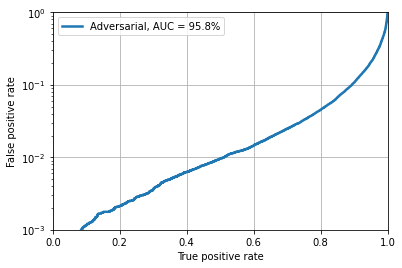

In [10]:
# create ROC curves
print(label_array_test.shape)
print(spec_array_test.shape)
print(predict_array_adv.shape)
fpr_adv, tpr_adv, threshold_adv = roc_curve(label_array_test[:,1], predict_array_adv[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_adv, fpr_adv, lw=2.5, label="Adversarial, AUC = {:.1f}%".format(auc(fpr_adv,tpr_adv)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [11]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

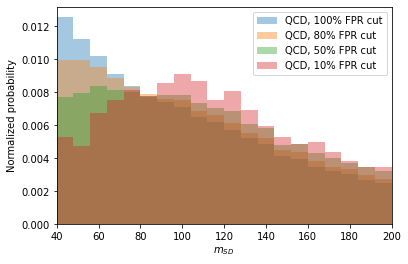

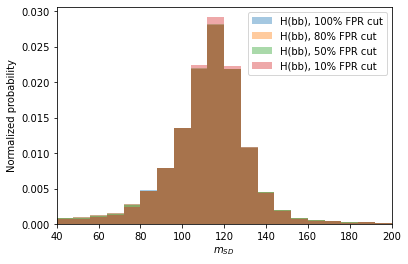

In [12]:
plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,0]*(predict_array_adv[:,1] > threshold_adv[idx]),
             alpha=0.4,density=True, label='QCD, {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)

plt.figure()
for wp in [1.0, 0.8, 0.5, 0.1]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins = np.linspace(40, 200, 21), 
             weights = label_array_test[:,1]*(predict_array_adv[:,1] > threshold_adv[idx]),
             alpha=0.4,density=True, label='H(bb), {}% FPR cut'.format(int(wp*100)),linestyle='-')
plt.legend()
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability')
plt.xlim(40,200)
plt.show()